# AML Week 2, Lecture 2: Sequence Models

## Learning Objectives

- How to build, fit, and evaluat sequence models (SimpleRNN, LSTM, GRU, Bidrectional)
- How to use Global Average Pooling + return_sequences=True
- How to use pre-trained word embeddings for modeling.


In [1]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

# MacOS Sonoma Fix
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Adding parent directory to python path
import os, sys
sys.path.append(os.path.abspath("../"))

In [3]:
## Load the autoreload extension
!pip install -U dojo_ds -q
import dojo_ds as ds
# %load_ext autoreload 
# %autoreload 2

# import custom_functions_SOLUTION  as fn

In [4]:
import json, joblib
with open("config/filepaths.json") as f:
    FPATHS = json.load(f)
FPATHS['data']['processed-nlp']

{'processed-reviews-spacy_json': 'data/processed/processed-reviews.json',
 'processed-reviews-spacy_joblib': 'data/processed/processed-reviews.joblib',
 'processed-reviews-with-target_json': 'data/processed/processed-reviews-with-target.json',
 'processed-reviews-with-target_joblib': 'data/processed/processed-reviews-with-target.joblib'}

## Data

In [5]:
from IPython.display import display, Markdown
with open("data/Amazon Product Reviews.md") as f:
    display(Markdown(f.read()))

# Amazon Product Reviews

- URL: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews 

## Description

This is a large crawl of product reviews from Amazon. This dataset contains 82.83 million unique reviews, from around 20 million users.

## Basic statistics

| Ratings:  | 82.83 million        |
| --------- | -------------------- |
| Users:    | 20.98 million        |
| Items:    | 9.35 million         |
| Timespan: | May 1996 - July 2014 |

## Metadata

- reviews and ratings
- item-to-item relationships (e.g. "people who bought X also bought Y")
- timestamps
- helpfulness votes
- product image (and CNN features)
- price
- category
- salesRank

## Example

```
{  "reviewerID": "A2SUAM1J3GNN3B",  "asin": "0000013714",  "reviewerName": "J. McDonald",  "helpful": [2, 3],  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",  "overall": 5.0,  "summary": "Heavenly Highway Hymns",  "unixReviewTime": 1252800000,  "reviewTime": "09 13, 2009" }
```

## Download link

See the [Amazon Dataset Page](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/) for download information.

The 2014 version of this dataset is [also available](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html).

## Citation

Please cite the following if you use the data:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**

R. He, J. McAuley

*WWW*, 2016
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/www16a.pdf)

**Image-based recommendations on styles and substitutes**

J. McAuley, C. Targett, J. Shi, A. van den Hengel

*SIGIR*, 2015
[pdf](https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf)

In [6]:
import pandas as pd 
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [7]:
import joblib
# df = joblib.load('data/processed/processed-reviews.joblib')
df = pd.read_json(FPATHS['data']['processed-nlp']['processed-reviews-with-target_json'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 0 to 4362
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   asin                  4363 non-null   object
 1   reviewerID            4363 non-null   object
 2   reviewText            4363 non-null   object
 3   summary               4363 non-null   object
 4   overall               4363 non-null   int64 
 5   year                  4363 non-null   int64 
 6   title                 4363 non-null   object
 7   brand                 4363 non-null   object
 8   category              4363 non-null   object
 9   review-text-full      4363 non-null   object
 10  review-text-full_raw  4363 non-null   object
 11  tokens-dirty          4363 non-null   object
 12  tokens                4363 non-null   object
 13  lemmas                4363 non-null   object
 14  tokens-dirty-joined   4363 non-null   object
 15  tokens-joined         4363 non-null   

,asin,reviewerID,reviewText,summary,overall,year,title,brand,category,review-text-full,review-text-full_raw,tokens-dirty,tokens,lemmas,tokens-dirty-joined,tokens-joined,lemmas-joined,target-rating
0,B007JINB0W,A3Y51NV9HU5T2,"Great pasta taste and feel, but the spell in the packaged is SKRONG!",Four Stars,4,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","Four Stars: Great pasta taste and feel, but the spell in the packaged is SKRONG!","[four, stars, great, pasta, taste, and, feel, but, the, spell, in, the, packaged, is, skrong]","[stars, great, pasta, taste, feel, spell, packaged, skrong]","[star, great, pasta, taste, feel, spell, package, skrong]",four stars great pasta taste and feel but the spell in the packaged is skrong,stars great pasta taste feel spell packaged skrong,star great pasta taste feel spell package skrong,None
1,B007JINB0W,A3D7EFSRC6Y9MP,"The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.",Okay but don't like texture,3,2014,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,"Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","Okay but don't like texture: The texture just made it a little strange to eat. Otherwise the flavor is okay, very bland so add spices.","[okay, but, do, n't, like, texture, the, texture, just, made, it, a, little, strange, to, eat, otherwise, the, flavor, is, okay, very, bland, so, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spices]","[okay, like, texture, texture, little, strange, eat, flavor, okay, bland, add, spice]",okay but do n't like texture the texture just made it a little strange to eat otherwise the flavor is okay very bland so add spices,okay like texture texture little strange eat flavor okay bland add spices,okay like texture texture little strange eat flavor okay bland add spice,None
2,B007JINB0W,A4AM5KBP3I2R,The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,Go for the green noodles: The herb flavor makes the odd texture of shirataki much more palatable.,"[go, for, the, green, noodles, the, herb, flavor, makes, the, odd, texture, of, shirataki, much, more, palatable]","[green, noodles, herb, flavor, makes, odd, texture, shirataki, palatable]","[green, noodle, herb, flavor, make, odd, texture, shirataki, palatable]",go for the green noodles the herb flavor makes the odd texture of shirataki much more palatable,green noodles herb flavor makes odd texture shirataki palatable,green noodle herb flavor make odd texture shirataki palatable,High
3,B007JINB0W,A3GHK4IL78DB7Y,I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of the initial smell is to boil it will a cube of bo...,Its an awesome substitute.,5,2018,"Miracle Noodle Zero Carb, Gluten Free Shirataki Pasta, Spinach Angel Hair, 7-Ounce (Pack of 24)",Miracle Noodle,Grocery & Gourmet Food; Pasta & Noodles; Noodles; Shirataki,Its an awesome substitute.: I didn't have a problem at all with a half filled bag or anything that other users said. I was concerned at first but I took a chance and there were no problems.\nI find the best way to get rid of the i

In [8]:
# def create_groups(x):
#     if x>=5.0:
#         return "high"
#     elif x <=2.0:
#         return "low"
#     else: 
#         return None

To understand what customers do and do not like about Hoover products, we will define 2 groups:
- High Ratings
    - Overall rating = 5.0
- Low Ratings
    - Overall rating = 1.0 or 2.0


We can use a function and .map to define group names based on the numeric overall ratings.

In [9]:
# ## Use the function to create a new "rating" column with groups
# df['rating'] = df['overall'].map(create_groups)
# df['rating'].value_counts(dropna=False)

In [10]:
# ## Check class balance of 'rating'
# df['target-rating'].value_counts(normalize=True)

In [11]:
# # Create a df_ml without null ratings
# df_ml = df.dropna(subset=['rating']).copy()
# df_ml.isna().sum()

In [12]:
# ## X - Option A)  lemmas
# # def join_tokens(token_list):
# #     joined_tokens = ' '.join(token_list)
# #     return joined_tokens
# # X = df_ml['spacy_lemmas'].apply(join_tokens)

# # X - Option B) original raw text
# X = df_ml['text']

# # y - use our binary target 
# y = df_ml['rating']
# X.head(10)

In [13]:
X_train, y_train = joblib.load(FPATHS['data']['ml-nlp']['train_joblib'])
X_test, y_test = joblib.load(FPATHS['data']['ml-nlp']['test_joblib'])
encoder = joblib.load(FPATHS['metadata']['label_encoder_joblib'])

In [14]:
X_train.head()

2947    Great!: This stuff is a miracle. Rinse very well for a few minutes, then boil for a couple minutes, then dry fry it in a pan and trim the pasta. I just made chicken pad thai with it. I made my own sauce so the whole meal was low carb. This is bec...
3613                                                                                                                                             Not For Me: When you give up on trying  to chew this up, just swallow it whole.one two three four five six seven
864                                                                                                                                                                       Texture is chewy and smelled like fish!: Nasty! Texture is chewy and smelled like fish!
1872                                                                                                                                      Not a good purchase for me: Opened the package. Yuck.  Followed the directions. Still Yu

In [15]:
pd.Series(encoder.inverse_transform(y_train)).value_counts()

High    1376
Low     1102
dtype: int64

## From Train-Test Split for ML to Train-Test-Val Split for ANNs

- Starting with a simple train-test-split for ML model (like in movie nlp project)
- Resampling Imbalanced training data
- Creating tensorflow dataset from X_train, y_train (so dataset is rebalanced)
- Creating tensorflow dataset (intended to be split in 2 ) for X_test and y_test

In [16]:
# # Perform 70:30 train test split
# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.3, random_state=42)
# len(X_train_full), len(X_test)

### Using Sklearn's LabelEncoder

- Can't use text labels with neural networks.

In [17]:
# y_train_full[:10]

In [18]:
# # Instansiate label encoder
# encoder = LabelEncoder()

# # Fit and transform the training target
# y_train_full_enc = encoder.fit_transform(y_train_full)#.values)

# # Fit and tranform the test target
# y_test = encoder.transform(y_test)

# y_train_full_enc[:10]

In [19]:
# Original Class names saved as .classes_
classes = encoder.classes_
classes

array(['High', 'Low'], dtype=object)

In [20]:
# Can inverse-transform 
encoder.inverse_transform([0,1])

array(['High', 'Low'], dtype=object)

### Undersampling Majority Class

In [21]:
# from imblearn.under_sampling import RandomUnderSampler

# # Instantiate a RandomUnderSampler
# sampler = RandomUnderSampler(random_state=42)

In [22]:
# # Fit_resample on the reshaped X_train data and y-train data
# X_train, y_train = sampler.fit_resample(X_train_full.values.reshape(-1,1),
#                                         y_train_full_enc)
# X_train.shape

In [23]:
# # Flatten the reshaped X_train data back to 1D
# X_train = X_train.flatten()
# X_train.shape

In [24]:
# # Check for class balance
# pd.Series(y_train).value_counts()

## Previous ML Model

In [25]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



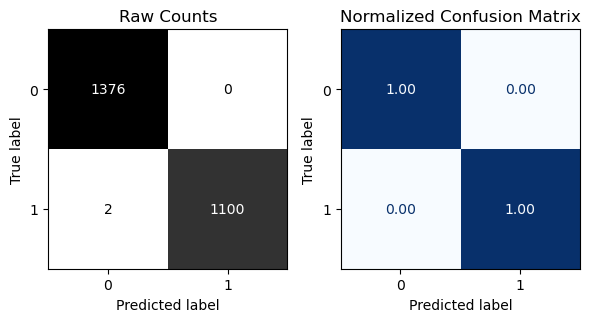


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       492
           1       0.92      0.94      0.93       335

    accuracy                           0.94       827
   macro avg       0.94      0.94      0.94       827
weighted avg       0.94      0.94      0.94       827



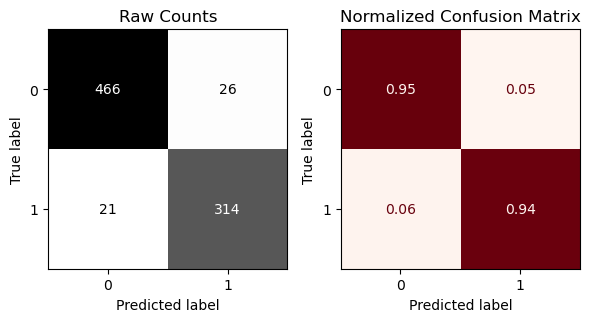

In [26]:
## Create a model pipeline 
clf_pipe = Pipeline([('vectorizer',  TfidfVectorizer(ngram_range=(1,2), stop_words='english')), 
                       ('logreg',  LogisticRegression(C=1e12,max_iter=200))])

clf_pipe.fit(X_train, y_train)
ds.evaluate.evaluate_classification(clf_pipe, X_train, y_train, X_test, y_test,)

## Preparing For Deep NLP (Train-Test-Val Datasets)

Since we already have train/test X and y vars, we will make 2 dataset objects using tf.data.Dataset.from_tensor_slices.

1. The training dataset using X_train, y_train (that we resampled/balanced)
2. The val/test dataset using X_test, y-test.

We will then split the val/test dataset into a val/test split.

<!-- 
### T/T/V Split - Order of Operations (if using 1 dataset object)

1) **Create full dataset object & Shuffle Once.**
2) Calculate number of samples for training and validation data.
3) Create the train/test/val splits using .take() and .skip()
4) **Add shuffle to the train dataset only.**
5) (Optional/Not Used on LP) If applying a transformation (e.g. train_ds.map(...)) to the data, add  here, before .cache()
7) (Optional) Add .cache() to all splits to increase speed  (but may cause problems with large datasets)
8) **Add .batch to all splits (default batch size=32)**
9) (Optional) Add .prefetch(tf.data.AUTOTUNE)
10) (Optional) Print out final length of datasets -->

In [27]:
# Convert training data to Dataset Object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Shuffle dataset once
train_ds = train_ds.shuffle(len(train_ds),seed=42, reshuffle_each_iteration=False)

Create a test and validation dataset using X_test,y_test

In [28]:
# Convert test to dataset object to split
val_test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [29]:
# Calculate # of samples for 50/50 val/test split
n_val_samples = int(len(val_test_ds) *.5)
n_val_samples

413

In [30]:
## Perform the val/test split


## Create the validation dataset using .take
val_ds = val_test_ds.take(n_val_samples)

## Create the test dataset using skip
test_ds = val_test_ds.skip(n_val_samples)

In [31]:
# Comparing the len gths of all 3 splits
len(train_ds), len(val_ds), len(test_ds)

(2478, 413, 414)

### Adding Shuffling and Batching

Let's examine a single element.

In [32]:
# display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"... can only say what I thought of them - HORRIBLE! Both the taste and texture were terrible: I can only say what I thought of them - HORRIBLE! Both the taste and texture were terrible.  The consistency made me nauseous.  Normally I give things away if I either don't like them or I cannot use them.  I could not finish the small serving I had because it was so awful.  My husband tasted them and he said he would rather starve than eat them.  I threw away the rest of the opened package and all of the unopened packages.  I would not try to inflict that on my worst enemy!", shape=(), dtype=string) 

 tf.Tensor(1, shape=(), dtype=int64)


In [33]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"... can only say what I thought of them - HORRIBLE! Both the taste and texture were terrible: I can only say what I thought of them - HORRIBLE! Both the taste and texture were terrible.  The consistency made me nauseous.  Normally I give things away if I either don't like them or I cannot use them.  I could not finish the small serving I had because it was so awful.  My husband tasted them and he said he would rather starve than eat them.  I threw away the rest of the opened package and all of the unopened packages.  I would not try to inflict that on my worst enemy!", shape=(), dtype=string) 

 tf.Tensor(1, shape=(), dtype=int64)


Notice that we have the same example, the training data is not shuffling.

Add .shuffle the training data.

In [34]:
# Shuffle only the training data every epoch
train_ds = train_ds.shuffle(len(train_ds), seed=42)

In [35]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)

tf.Tensor(b"Great tasting!: I just love miracle noodles when I'm in the mood to lower my caloric intake;)", shape=(), dtype=string) 

 tf.Tensor(0, shape=(), dtype=int64)


> Add batching (use 32 for batch_size)

In [36]:
#  Setting the batch_size for all datasets
BATCH_SIZE =32
# use .batch to add batching to all 3 datasets
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 78 training batches.
 There are 13 validation batches.
 There are 13 testing batches.


In [37]:
# (Repeat) display a sample single element 
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X,'\n\n',example_y)


tf.Tensor(
[b'My favorite cult following pasta: Ok ok...I know they smell fishy when you open the bag.\n1) rinse for 2 or 3 minutes under cold water while your waiting for your water on the stove to boil.\n2) boil them for 4 minutes\n3) strain\n4) stir fry on stove with all kinds of delicious seasoning (whatever your flavor)\n5) enjoy\n\nFYI-my personal recipe is chimichuri seasoning with chopped up tomatos, cilantro and onions, olive oil, garlic powder, jalapeo powder, ginger powder, chili powder and topped with crushed flax seeds and shredded Parmesan cheese!'
 b'Great product but the texture may bother you: I have been following the "keto" diet for several months so I was excited to find a pasta-like product to try with zero carbs. I was skeptical when I first ordered this product but have reordered several times now and I really enjoy it, especially the "rice" version. If you enjoy traditional rice noodles, I would suggest giving this product a try, as it is quite similar in textur

A single element now contains 32 samples since we set  batch_size to 32.

### Create the Training Texts Dataset

> We need to get a version of our data that is **only the texts**.

In [38]:
# Get just the text_ds from ds_train
text_ds = train_ds.map(lambda x,y: x)
# Preview the text_ds
text_ds.take(1).get_single_element()

2024-02-14 18:08:18.950494: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Five Stars: Perfect',
       b'Yuk!: That was the nastiest thing I ever ate!! I was nauseated for two days! It smelled like fish. The texture was like rubber bands. ',
       b'Tasteless and rubbery: Better chew these "noodles" thoroughly. They did fill me up.  I ate one package. I made them with a recipe from their website.  Followed the instructions on the package: drain, rinse and boil. I then used them in a stir fry recipe.  Unlike the reviews which I have read online, they did NOT soak up the flavors of the sauce that I cooked them with; instead they remained tasteless and of a rubbery consistency. I found myself constipated for the next 24 hours. I know that the product may be an item of interest for those who are truly struggling to lose weight, but this item is not the way to go.',
       b'Better off making zucchini: They are so gross! I had such high hopes... but no! Better off making zucchini noodles',
       b"This stuf

### Determine appropriate sequence length. 

In [39]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
lengths_tokens = X_train.map(lambda x: len(x.split()))
lengths_tokens.describe()

count    2478.000000
mean       49.374899
std        60.495347
min         2.000000
25%        13.000000
50%        32.000000
75%        62.000000
max       997.000000
Name: review-text-full, dtype: float64

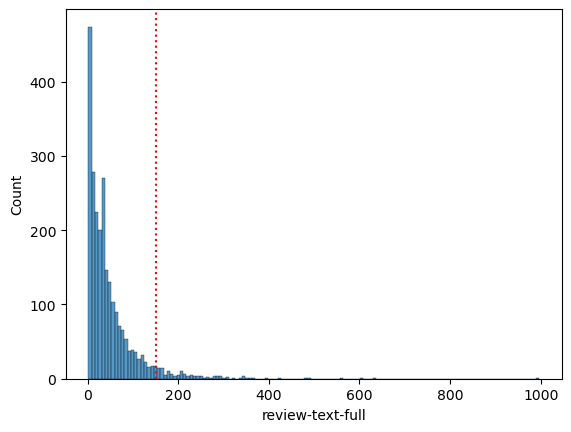

In [40]:
# Visualizing potential SEQUENCE_LENGTH
SEQUENCE_LENGTH = 150
ax = sns.histplot(lengths_tokens) 
ax.axvline(SEQUENCE_LENGTH, color='red', ls=":")

# Comparing Sequence Models

## Plan of Attack

>**We will fit and evaluate several iterations of the following:**
>- SimpleRNN:
    - With recurrent_dropout
    - Returning sequences and Averaging
> - LSTM:
    - Same as SimpleRNN
> - GRU:
    - Same as SimpleRNN

>**We will also try:**
> - Adding a Bidirectional layer
> - Using GloVe Pretrained word embeddings
> - Stacking multiple RNNS layers
> - Pretrained HuggingFace transformers

## Simple RNN

In [41]:
def build_rnn_model(text_vectorization_layer):
    
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add the SimpleRNN layer
    model.add(layers.SimpleRNN(32))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

def get_callbacks(patience=5,
                  monitor='val_accuracy',
                  start_from_epoch=0,
                 restore_best_weights=False):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, start_from_epoch=start_from_epoch,
                                                 restore_best_weights=restore_best_weights)
    return [early_stop]

In [42]:
## Create text Vectorization layer
SEQUENCE_LENGTH = 150
EMBED_DIM = 100

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(text_ds)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 150, 100)          566300    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 570,589
Trainable params: 570,589
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
78/78 [==============================] - 1s 14ms/step - loss: 0.6883 - accuracy: 0.5496 - val_loss: 0.684

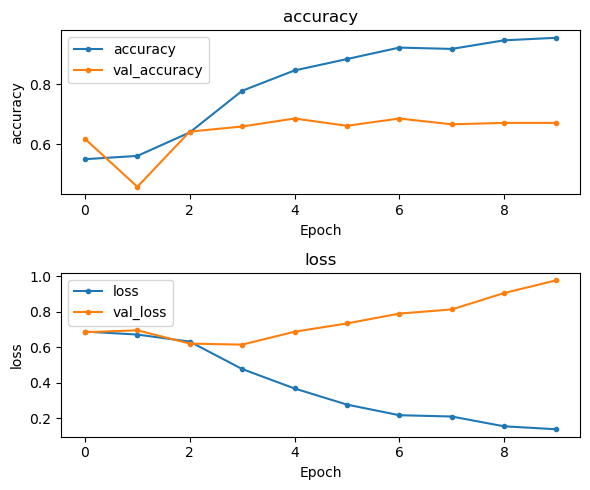

In [43]:
# Build the lstm model and specify the vectorizer
rnn_model = build_rnn_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1376
           1       0.97      0.97      0.97      1102

    accuracy                           0.97      2478
   macro avg       0.97      0.97      0.97      2478
weighted avg       0.97      0.97      0.97      2478



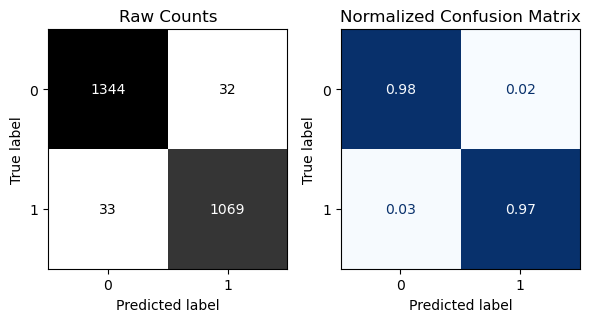


- Evaluating Training Data:
78/78 [==============================] - 0s 3ms/step - loss: 0.0971 - accuracy: 0.9738
{'loss': 0.09706879407167435, 'accuracy': 0.9737691879272461}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       238
           1       0.61      0.63      0.62       176

    accuracy                           0.67       414
   macro avg       0.67      0.67      0.67       414
weighted avg       0.68      0.67      0.67       414



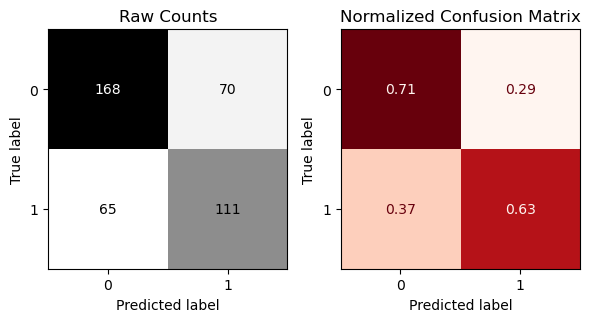


- Evaluating Test Data:
13/13 [==============================] - 0s 3ms/step - loss: 0.8095 - accuracy: 0.6739
{'loss': 0.8095124363899231, 'accuracy': 0.6739130616188049}


In [44]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    rnn_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> This model started overfitting very early. Let's add dropout and recurrent_dropout for the next model to prevent this.

### Adding Recurrent Dropout

In [45]:
# def build_rnn_model(text_vectorization_layer):
#     # Getting Text Parameters from TextVectorization Layer
#     VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
#     SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
#     # Define sequential model with pre-trained vectorization layer and *new* embedding layer
#     model = Sequential([
#         text_vectorization_layer,
#         layers.Embedding(input_dim=VOCAB_SIZE,
#                                   output_dim=EMBED_DIM, 
#                                   input_length=SEQUENCE_LENGTH)
#         ])
        
#     # Add recurrent_dropout=0.2 to the SimpleRNN 
#     model.add(layers.SimpleRNN(32, recurrent_dropout=0.2))
    
#     # Add output layer
#     model.add(layers.Dense(1, activation='sigmoid'))
 
#     # Compile the model
#     model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
#                   loss='bce',
#                   metrics=['accuracy'])
    
#     model.summary()
#     return model

In [46]:
# # Build the lstm model and specify the vectorizer
# rnn_model = build_rnn_model(sequence_vectorizer)

# # Defien number of epocs
# EPOCHS = 30
# # Fit the model
# history = rnn_model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=get_callbacks(patience=5)
# )
# ds.evaluate.plot_history(history,figsize=(6,5))

In [47]:
# # Obtain the results
# results = ds.evaluate.evaluate_classification_network(
#     rnn_model, X_train=train_ds, 
#     X_test=test_ds,# history=history
# );

> For this particular task/model, adding dropout and recurrent dropout did not seem to help. We could easily spend much more time trying alternative amounts of dropout. We could also tune the number of units, the optimizer, the learning rate, etc.


Next we will try returning the sequences and averaging them to see if this improves the model. 

## SimpleRNN - Return_sequences = True & Global Pooling

- We must set return_sequences = True  for the RNN layer, and then add the GlobalAveragePooling1D layer.

In [48]:
def build_rnn_model_pool(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
    
    # Add A SimpleRNN layer that will return sequences
    model.add(layers.SimpleRNN(32,return_sequences=True))

    ## Add a global average pooling 1d layer 
    model.add(layers.GlobalAveragePooling1D())
              
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 150, 100)          566300    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150, 32)           4256      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 570,589
Trainable params: 570,589
Non-tr

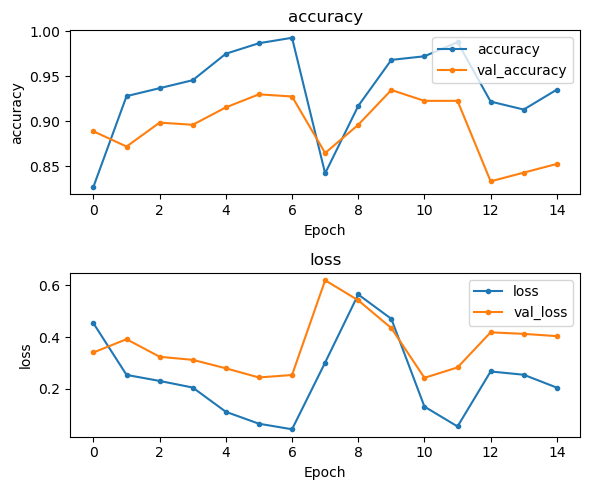

In [49]:
# Build the lstm model and specify the vectorizer
rnn_model_pool = build_rnn_model_pool(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = rnn_model_pool.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1376
           1       0.93      0.96      0.95      1102

    accuracy                           0.95      2478
   macro avg       0.95      0.95      0.95      2478
weighted avg       0.95      0.95      0.95      2478



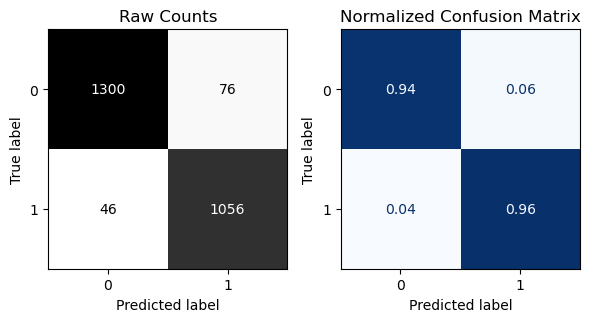


- Evaluating Training Data:
78/78 [==============================] - 0s 3ms/step - loss: 0.1697 - accuracy: 0.9508
{'loss': 0.16966558992862701, 'accuracy': 0.9507667422294617}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       238
           1       0.88      0.92      0.90       176

    accuracy                           0.91       414
   macro avg       0.91      0.91      0.91       414
weighted avg       0.91      0.91      0.91       414



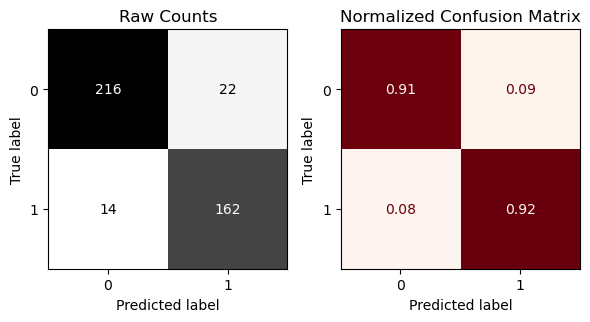


- Evaluating Test Data:
13/13 [==============================] - 0s 4ms/step - loss: 0.2770 - accuracy: 0.9130
{'loss': 0.2770044505596161, 'accuracy': 0.9130434989929199}


In [50]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    rnn_model_pool, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Using the average vector helped our model a lot! Notice how high the recall score is for the 1 class.  However, its still overfitting so lets try adding recurrent dropout and dropout regularization.

###  Using Recurrent Dropout + return_sequences=True and Global Pooling layer 

In [51]:
# def build_rnn_model_pool(text_vectorization_layer):
#     # Getting Text Parameters from TextVectorization Layer
#     VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
#     SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
#     # Define sequential model with pre-trained vectorization layer and *new* embedding layer
#     model = Sequential([
#         text_vectorization_layer,
#         layers.Embedding(input_dim=VOCAB_SIZE,
#                                   output_dim=EMBED_DIM, 
#                                   input_length=SEQUENCE_LENGTH)
#         ])
        
#     # Add recurrent_dropout = 0.2 and dropout=0.2 to prevous SimpleRNN
#     model.add(layers.SimpleRNN(32,recurrent_dropout=.2, dropout=.2,return_sequences=True))

#     ## Add a global average pooling 1d layer 
#     model.add(layers.GlobalAveragePooling1D())
              
    
#     # Add output layer
#     model.add(layers.Dense(1, activation='sigmoid'))
 
#     # Compile the model
#     model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
#                   loss='bce',
#                   metrics=['accuracy'])
    
#     model.summary()
#     return model


In [52]:
# ## Build the lstm model and specify the vectorizer
# rnn_model_pool = build_rnn_model_pool(sequence_vectorizer)

# # Defien number of epocs
# EPOCHS = 30
# # Fit the model
# history = rnn_model_pool.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=get_callbacks(patience=5)
# )
# ds.evaluate.plot_history(history,figsize=(6,5))

In [53]:
# # Obtain the results
# results = ds.evaluate.evaluate_classification_network(
#     rnn_model_pool, X_train=train_ds, 
#     X_test=test_ds,# history=history
# );

> Adding dropout and recurrent dropout helped our model with the 1 class. While have a lower accuracy, we have better recall for the 1 class.

There's a lot more we could tune, but let's move onto the next sequence model that was developed: the LSTM.

## LSTM

In [54]:
def build_lstm_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add an LSTM layer with 32 units
    model.add(layers.LSTM(32, recurrent_dropout=.3))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 150, 100)          566300    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 583,357
Trainable params: 583,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
78/78 [==============================] - 5s 50ms/step - loss: 0.6889 - accuracy: 0.5456 - val_loss: 0.6

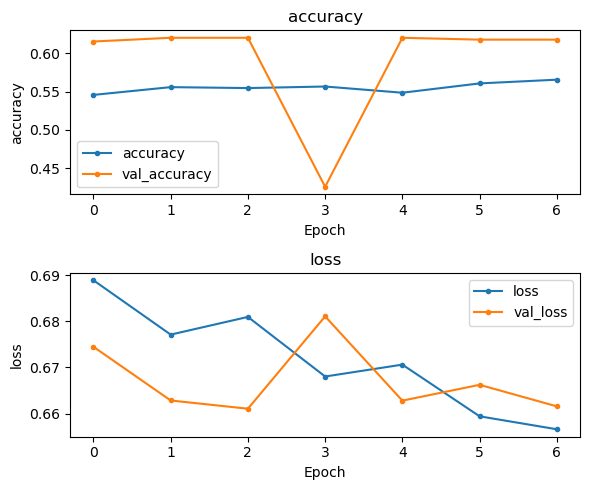

In [55]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1376
           1       1.00      0.03      0.06      1102

    accuracy                           0.57      2478
   macro avg       0.78      0.51      0.39      2478
weighted avg       0.76      0.57      0.42      2478



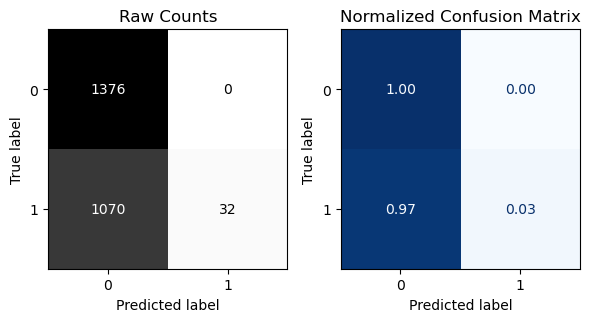


- Evaluating Training Data:
78/78 [==============================] - 1s 9ms/step - loss: 0.6566 - accuracy: 0.5682
{'loss': 0.6565930843353271, 'accuracy': 0.5682001709938049}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.97      0.71       238
           1       0.00      0.00      0.00       176

    accuracy                           0.56       414
   macro avg       0.28      0.48      0.36       414
weighted avg       0.33      0.56      0.41       414



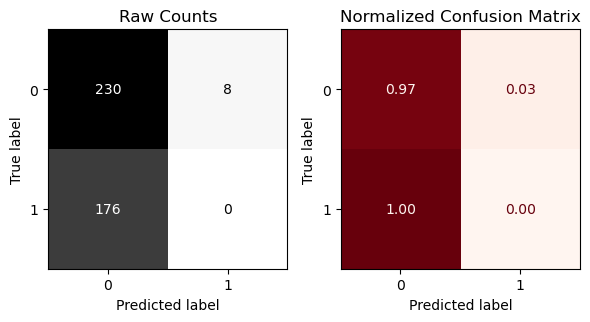


- Evaluating Test Data:
13/13 [==============================] - 0s 9ms/step - loss: 0.7072 - accuracy: 0.5556
{'loss': 0.7072221636772156, 'accuracy': 0.5555555820465088}


In [56]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> the baseline LSTM is already outperforming our baseline SimpleRNN model.  Let's try using the average word vectors again, since overfitting isn't as much of an issue vs. our earlier SimpleRNN.

In [57]:
FPATHS['models']['nn']

{'LSTM_dir': 'models/keras/lstm/',
 'GRU_dir': 'models/keras/gru/',
 'Attention_model_dir': 'models/keras/attn/'}

###  Using return_sequences=True and Global Pooling layer

In [58]:
def build_lstm_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add an LSTM layer that will return sequences
    model.add(layers.LSTM(32,return_sequences=True))
    
    ## Add a global average pooling 1d layer 
    model.add(layers.GlobalAveragePooling1D())

    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 150, 100)          566300    
                                                                 
 lstm_1 (LSTM)               (None, 150, 32)           17024     
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 583,357
Trainable params: 583,357
Non-tr

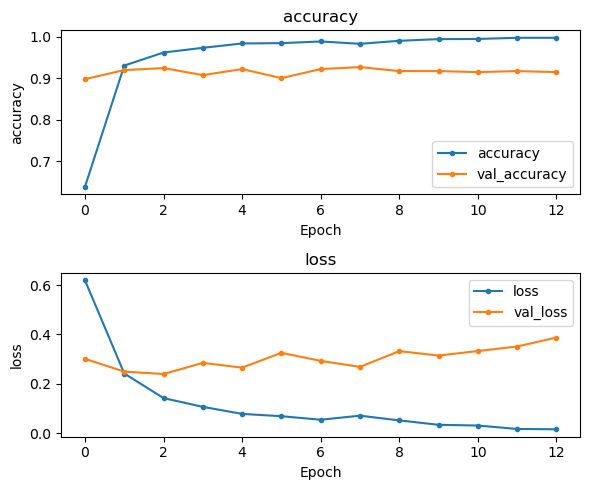

In [59]:

# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



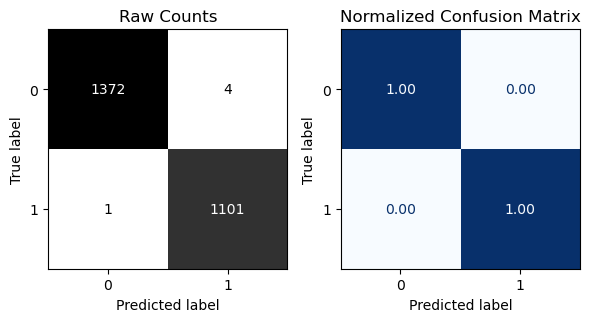


- Evaluating Training Data:
78/78 [==============================] - 1s 7ms/step - loss: 0.0157 - accuracy: 0.9980
{'loss': 0.015656275674700737, 'accuracy': 0.9979822635650635}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       238
           1       0.94      0.90      0.92       176

    accuracy                           0.93       414
   macro avg       0.93      0.93      0.93       414
weighted avg       0.93      0.93      0.93       414



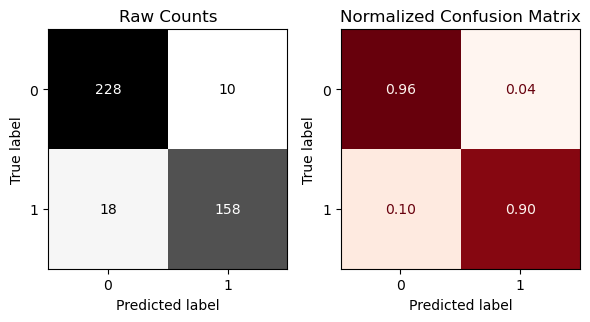


- Evaluating Test Data:
13/13 [==============================] - 0s 7ms/step - loss: 0.3386 - accuracy: 0.9324
{'loss': 0.33860504627227783, 'accuracy': 0.9323671460151672}


In [60]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Using the average sequence has helped our LSTM model as well. We have better accuracy and recall scores for both classes. The model started to overfit after epoch 4, so let's add recurrent dropout and dropout again.

### Add Dropout/Recurrent Dropout

In [61]:
def build_lstm_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add recurrent_dropout = 0.1 and dropout=0.1 to prevous LSTM
    model.add(layers.LSTM(32,recurrent_dropout=.1, dropout=.1, return_sequences=True))
    
    ## Add a global average pooling 1d layer 
    model.add(layers.GlobalAveragePooling1D())

    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 150, 100)          566300    
                                                                 
 lstm_2 (LSTM)               (None, 150, 32)           17024     
                                                                 
 global_average_pooling1d_2   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 583,357
Trainable params: 583,357
Non-tr

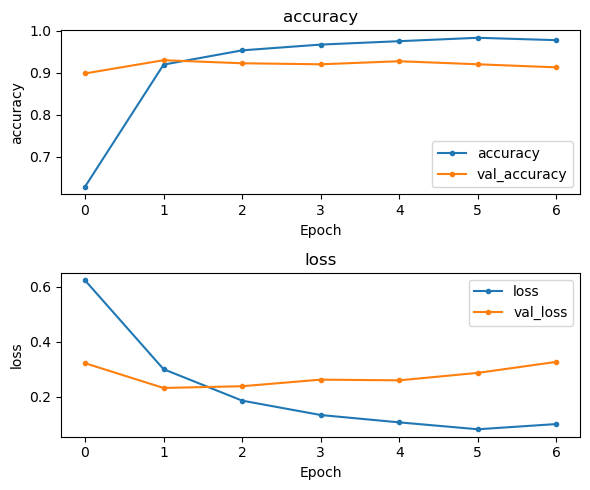

In [62]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1376
           1       0.99      0.97      0.98      1102

    accuracy                           0.98      2478
   macro avg       0.98      0.98      0.98      2478
weighted avg       0.98      0.98      0.98      2478



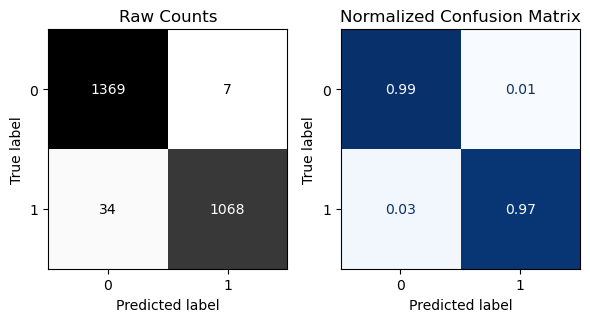


- Evaluating Training Data:
78/78 [==============================] - 1s 9ms/step - loss: 0.0794 - accuracy: 0.9835
{'loss': 0.07939412444829941, 'accuracy': 0.9834544062614441}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       238
           1       0.94      0.87      0.91       176

    accuracy                           0.92       414
   macro avg       0.93      0.92      0.92       414
weighted avg       0.92      0.92      0.92       414



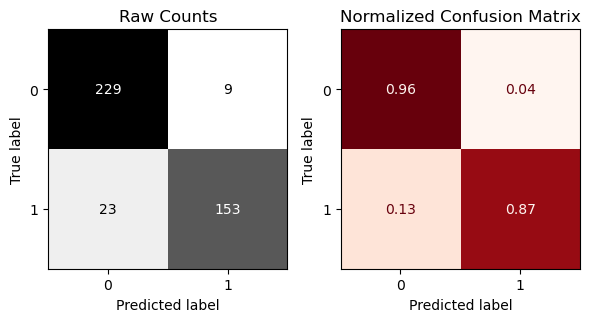


- Evaluating Test Data:
13/13 [==============================] - 0s 10ms/step - loss: 0.2978 - accuracy: 0.9227
{'loss': 0.29783353209495544, 'accuracy': 0.9227052927017212}


In [63]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> Adding dropout and recurrent_dropout has helped our model again. There are still other parameters we would try, but let's move onto the next sequence model that was developed: the GRU.

## GRU

In [64]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add a GRU layer with 32 units
    model.add(layers.GRU(32)) 
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 150, 100)          566300    
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 579,197
Trainable params: 579,197
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
78/78 [==============================] - 3s 31ms/step - loss: 0.6895 - accuracy: 0.5391 - val_loss: 0.6

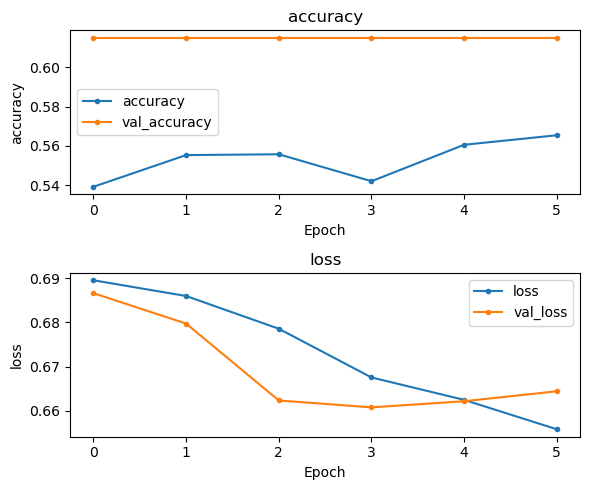

In [65]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history, figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.56      1.00      0.72      1376
           1       1.00      0.03      0.05      1102

    accuracy                           0.57      2478
   macro avg       0.78      0.51      0.38      2478
weighted avg       0.76      0.57      0.42      2478



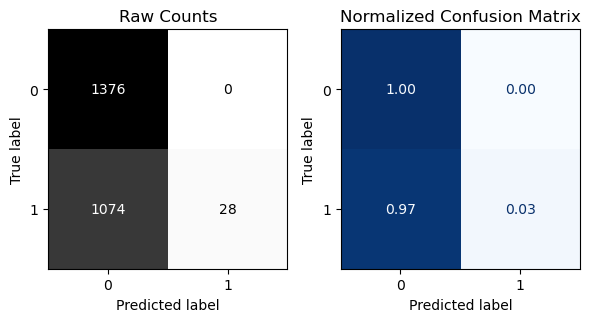


- Evaluating Training Data:
78/78 [==============================] - 0s 6ms/step - loss: 0.6536 - accuracy: 0.5666
{'loss': 0.6536166667938232, 'accuracy': 0.5665859580039978}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.99      0.73       238
           1       0.00      0.00      0.00       176

    accuracy                           0.57       414
   macro avg       0.29      0.50      0.36       414
weighted avg       0.33      0.57      0.42       414



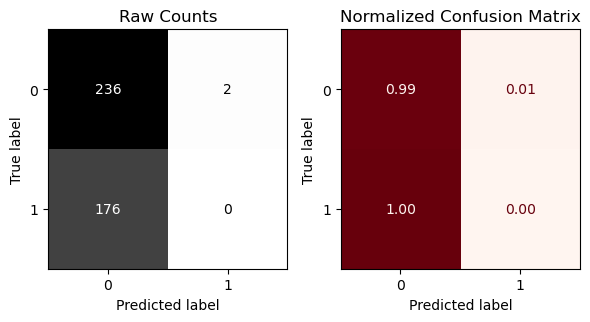


- Evaluating Test Data:
13/13 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.5700
{'loss': 0.6852630972862244, 'accuracy': 0.5700483322143555}


In [66]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> The basline GRU is peforming much worse than the baseline LSTM. The accuracy and val_accuracy stayed pretty flat for much of the training epochs and the model is very biased towards predicting the 0 class. Our current GRU model may not be complex enough.
> We can try increasing the number of GRU units and a faster learning rate.

### GRU + More Units + Learning Rate

In [67]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add a GRU layer with 64 units
    model.add(layers.GRU(64)) 
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), #Increase  learning rate to .01                                                
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 150, 100)          566300    
                                                                 
 gru_1 (GRU)                 (None, 64)                31872     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,237
Trainable params: 598,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
78/78 [==============================] - 4s 44ms/step - loss: 0.6883 - accuracy: 0.5331 - val_loss: 0.6

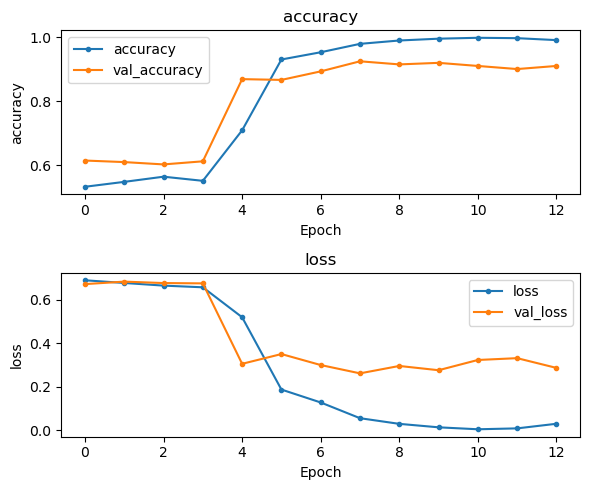

In [68]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history, figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1376
           1       0.99      0.99      0.99      1102

    accuracy                           0.99      2478
   macro avg       0.99      0.99      0.99      2478
weighted avg       0.99      0.99      0.99      2478



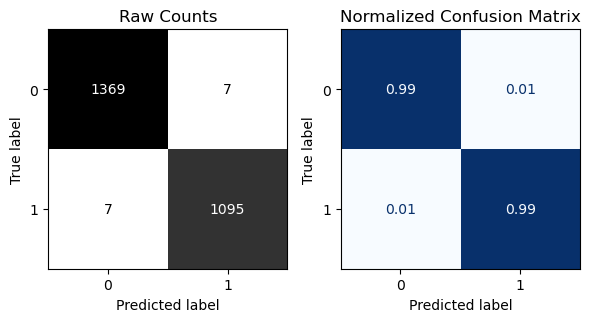


- Evaluating Training Data:
78/78 [==============================] - 1s 9ms/step - loss: 0.0175 - accuracy: 0.9944
{'loss': 0.01753760501742363, 'accuracy': 0.994350254535675}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       238
           1       0.89      0.94      0.91       176

    accuracy                           0.92       414
   macro avg       0.92      0.92      0.92       414
weighted avg       0.92      0.92      0.92       414



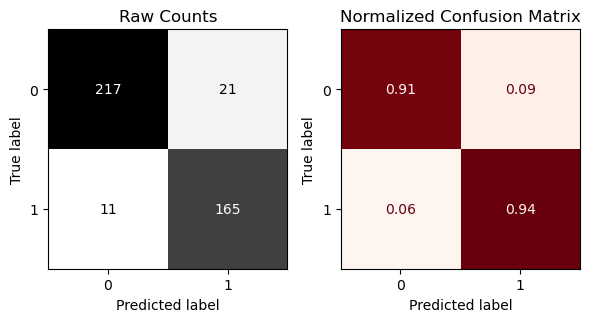


- Evaluating Test Data:
13/13 [==============================] - 0s 9ms/step - loss: 0.2605 - accuracy: 0.9227
{'loss': 0.260464072227478, 'accuracy': 0.9227052927017212}


In [69]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> The increased complexity (nunits) plus faster learning rate helped dramatically! The model is overfitting so let's add dropout as well.

### Add Dropout/Recurrent Dropout

In [70]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add recurrent_dropout = 0.2 and dropout=0.2 to prevous GRU
    model.add(layers.GRU(64,recurrent_dropout=.2, dropout=.2))#, recurrent_dropout=.2, dropout=.1))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
        # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,#optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_7 (Embedding)     (None, 150, 100)          566300    
                                                                 
 gru_2 (GRU)                 (None, 64)                31872     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 598,237
Trainable params: 598,237
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
78/78 [==============================] - 8s 89ms/step - loss: 0.6926 - accuracy: 0.5460 - val_loss: 0.6

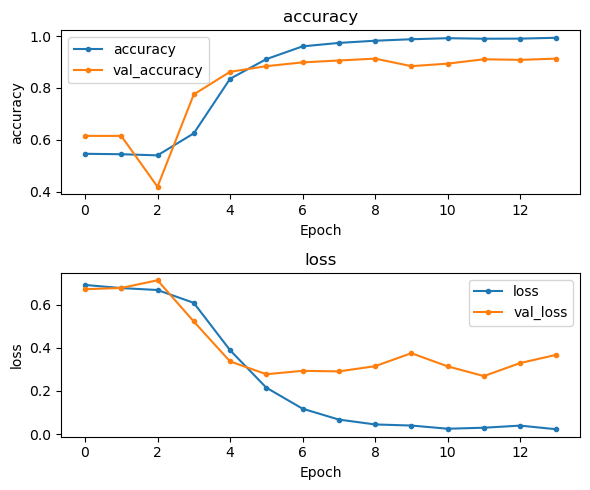

In [71]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



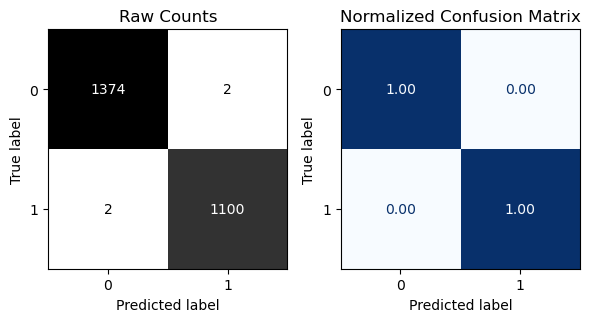


- Evaluating Training Data:
78/78 [==============================] - 1s 11ms/step - loss: 0.0058 - accuracy: 0.9984
{'loss': 0.005762266926467419, 'accuracy': 0.9983857870101929}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       238
           1       0.90      0.90      0.90       176

    accuracy                           0.91       414
   macro avg       0.91      0.91      0.91       414
weighted avg       0.91      0.91      0.91       414



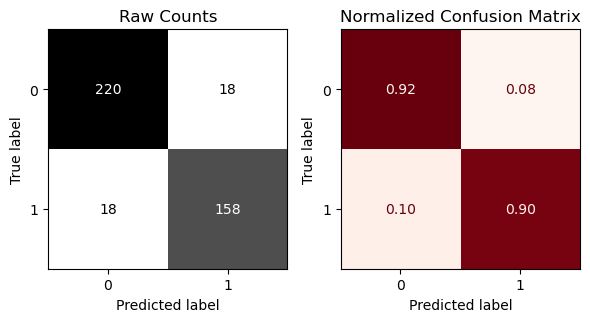


- Evaluating Test Data:
13/13 [==============================] - 0s 12ms/step - loss: 0.3342 - accuracy: 0.9130
{'loss': 0.3341676890850067, 'accuracy': 0.9130434989929199}


In [72]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> This GRU is struggling with our current task. This may be due to insufficient complexity. One way we can increaser the complexity is to combine 2 GRU layers stacked together. Using multiple layers with fewer units is generally preferable to increasre the number of units in a single layer.

In [73]:
# raise Exception("Stop and re-evaluate what model to do next")

## Stacked GRU

In [74]:
def build_stacked_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add GRU layer with 64 units, recurrent dropout =0.1 , and return sequences
    model.add(layers.GRU(32,recurrent_dropout=0.1, return_sequences=True))
    # Add a dropout layer set to 0.2
    model.add(layers.Dropout(.2))
    # Add GRU layer with 64 units, recurrent dropout =0.1 , and do NOT return sequences
    model.add(layers.GRU(64,recurrent_dropout=0.1,return_sequences=False))

    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
            # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
    )  
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,#optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 embedding_8 (Embedding)     (None, 150, 100)          566300    
                                                                 
 gru_3 (GRU)                 (None, 150, 32)           12864     
                                                                 
 dropout (Dropout)           (None, 150, 32)           0         
                                                                 
 gru_4 (GRU)                 (None, 64)                18816     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                      

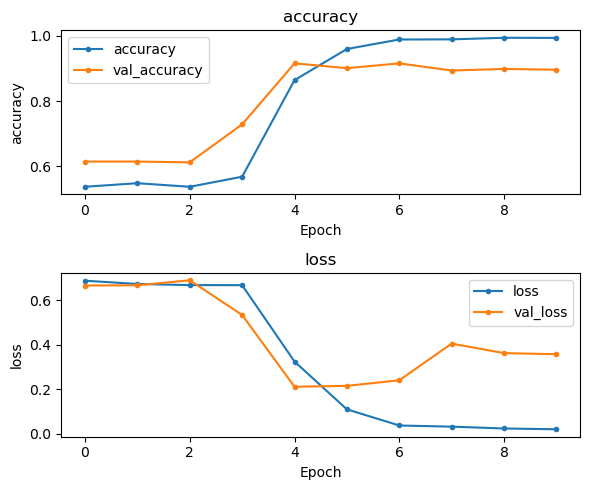

In [75]:
# Build the lstm model and specify the vectorizer
stacked_gru_model = build_stacked_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = stacked_gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1376
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2478
   macro avg       1.00      1.00      1.00      2478
weighted avg       1.00      1.00      1.00      2478



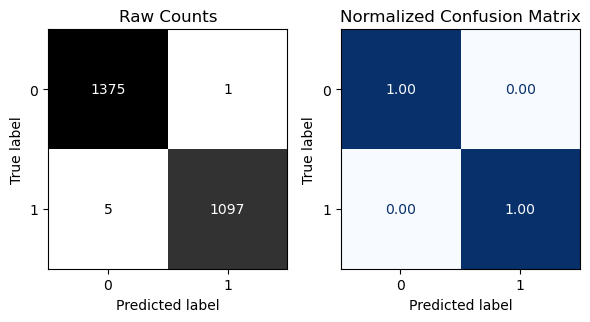


- Evaluating Training Data:
78/78 [==============================] - 1s 15ms/step - loss: 0.0112 - accuracy: 0.9976
{'loss': 0.011161873117089272, 'accuracy': 0.9975786805152893}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       238
           1       0.90      0.90      0.90       176

    accuracy                           0.92       414
   macro avg       0.91      0.91      0.91       414
weighted avg       0.92      0.92      0.92       414



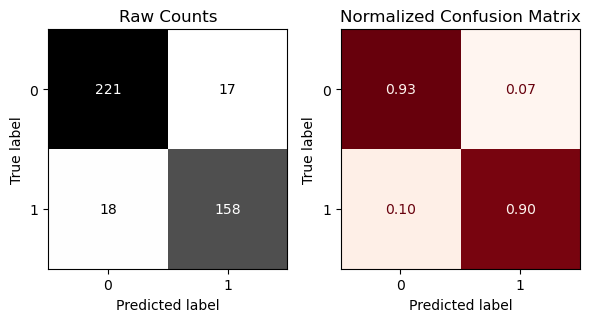


- Evaluating Test Data:
13/13 [==============================] - 0s 15ms/step - loss: 0.3220 - accuracy: 0.9155
{'loss': 0.32202228903770447, 'accuracy': 0.9154589176177979}


In [76]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    stacked_gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

### Using Return Sequences = True + GlobalAveragePooling

In [77]:
def build_stacked_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add GRU layer with 64 units, recurrent dropout =0.1 , and return sequences
    model.add(layers.GRU(32,recurrent_dropout=0.2, return_sequences=True))
    # Add a dropout layer set to 0.2
    model.add(layers.Dropout(.4))
    # Add GRU layer with 64 units, recurrent dropout =0.1 , and  return sequences
    model.add(layers.GRU(32,recurrent_dropout=0.2,return_sequences=True))

    ## Add the global pooling 1D layer
    model.add(layers.GlobalAveragePooling1D())
    
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
        # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=100000,
        decay_rate=0.95
    )  
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,#optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


In [78]:
## Create text Vectorization layer
SEQUENCE_LENGTH = 150
EMBED_DIM = 100

sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

sequence_vectorizer.adapt(text_ds)
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 150)              0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 150, 100)          566300    
                                                                 
 gru_5 (GRU)                 (None, 150, 32)           12864     
                                                                 
 dropout_1 (Dropout)         (None, 150, 32)           0         
                                                                 
 gru_6 (GRU)                 (None, 150, 32)           6336      
                                                                 
 global_average_pooling1d_3   (None, 32)               0         
 (GlobalAveragePooling1D)                             

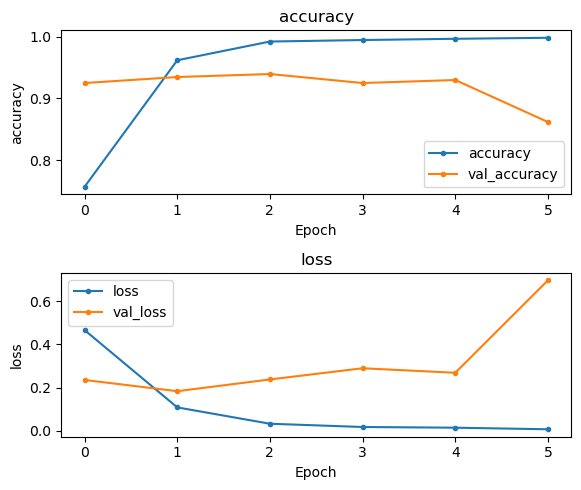

In [79]:
# Build the lstm model and specify the vectorizer
stacked_gru_model = build_stacked_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = stacked_gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=3)
)
ds.evaluate.plot_history(history,figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      0.93      0.97      1376
         Low       0.92      1.00      0.96      1102

    accuracy                           0.96      2478
   macro avg       0.96      0.97      0.96      2478
weighted avg       0.97      0.96      0.96      2478



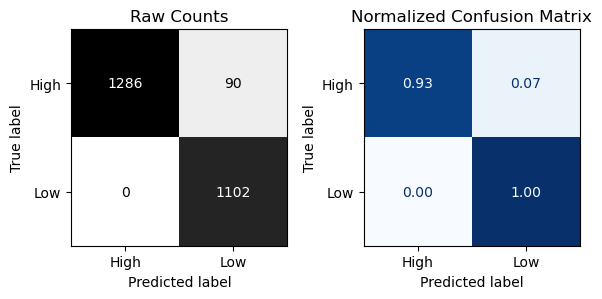


- Evaluating Training Data:
78/78 [==============================] - 1s 13ms/step - loss: 0.1258 - accuracy: 0.9637
{'loss': 0.12579604983329773, 'accuracy': 0.9636803865432739}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.99      0.75      0.85       238
         Low       0.75      0.99      0.85       176

    accuracy                           0.85       414
   macro avg       0.87      0.87      0.85       414
weighted avg       0.89      0.85      0.85       414



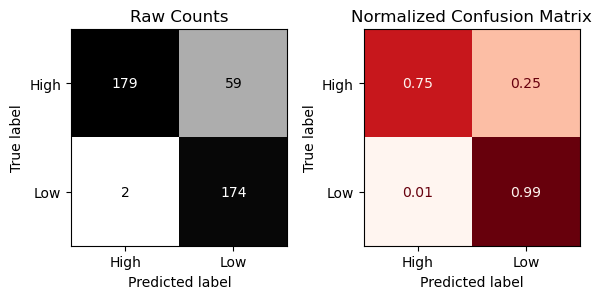


- Evaluating Test Data:
13/13 [==============================] - 0s 14ms/step - loss: 0.5596 - accuracy: 0.8527
{'loss': 0.5596044659614563, 'accuracy': 0.8526570200920105}


In [80]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    stacked_gru_model, X_train=train_ds,
    X_test=test_ds, target_names=encoder.classes_,# history=history
);

In [81]:
# raise Exception("stop here")

In [82]:
model_fpath = FPATHS['models']['nn']['GRU_dir']
model_fpath

'models/keras/gru/'

In [83]:
# stacked_gru_model.save(model_fpath,overwrite=False, save_format='tf')

In [84]:
pause

NameError: name 'pause' is not defined

> The stacked GRU with the global pooling layer improved vs. the previous model.
> There is more we could continue to tune, of course, (nunits, dropout, optimizer, etc.)
> An extension of using a stacked model is using a Bidrectional layer, which will make a duplicate of the layer inside it.
> The second layer will receive the sequences in the reverse order.

## Bidirectional

In [ ]:
def build_bi_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add a Bidirectional layer wrapped around a GRU layer with:
    ## 64 units,recurrent_dropout=0.2, dropout=0,2
    model.add(layers.Bidirectional(layers.GRU(32, recurrent_dropout=.2, dropout=.2),))
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=100000,
        decay_rate=0.95
    )  
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,#optimizers.legacy.Adam(learning_rate = .01),  
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


In [ ]:
# Build the lstm model and specify the vectorizer
bi_gru_model = build_bi_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = bi_gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))

In [ ]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    bi_gru_model, X_train=train_ds, 
    X_test=test_ds, # history=history
);

> We could also attempt using the average vectors by adding the GlobalAveragePooling layer.
>
> 
> We could continue to explore bidirectional models and revisit SimpleRNNs and LSTMs. Bidirectional Layers can be used with any of the sequence models we've covered.

###  Using GloVe Embeddings

- [Click here](https://nlp.stanford.edu/data/glove.6B.zip) to start donwnloading GloVe zip file (glove.6B.zip)
- Unzip the downloaded zip archive.
- Open the extracted folder and find the the `glove.6B.100d.txt` file. (Size is over 300MB )
- Move the text file from Downloads to the same folder as this notebook.
- **Make sure to ignore the large file using GitHub Desktop**

In [ ]:
from gensim.models import KeyedVectors
# Load GloVe vectors into a gensim model
glove_model = KeyedVectors.load_word2vec_format("data/glove/glove.6B.100d.txt", binary=False, no_header=True)

In [ ]:
# You can now use `glove_model` to access individual word vectors, similar to a dictionary
vector = glove_model['king']
vector

In [ ]:
vector.shape

In [ ]:
# Find similarity between words
glove_model.similarity('king', 'queen')

In [ ]:
# Perform word math
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)
result

In [ ]:
# We can use glove to calculate the most similar
glove_model.most_similar('king')

In [ ]:
# Manually calculating new vector for word math
new_vector = glove_model['king'] - glove_model['man'] + glove_model['woman']
new_vector

In [ ]:
# Using .most_similar with an array
glove_model.most_similar(new_vector)

In [ ]:
# Manually calculating new vector for word math
new_vector = glove_model['monarchy'] + glove_model['vote'] + glove_model['government']
glove_model.most_similar(new_vector)

In [ ]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['age']
glove_model.most_similar(new_vector)

In [ ]:
# Manually calculating new vector for word math
new_vector = glove_model['baby'] + glove_model['baby']
glove_model.most_similar(new_vector)

### Using Pre-trained Vectors in The Embedding Layer

In [ ]:
# Save the vocab size for creating embedding matrix 
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [ ]:
# Initialize an empty matrix the same shape as our EMbedding layer 
# to hold the word vectors from GloVe
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
embedding_matrix

In [ ]:
# Can save a list of words that were not found
unmatched_vocab = []

# Loop to get each word from vocabulary and get its pre-trained vector from GloVe model
for i, word in enumerate(sequence_vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i] = glove_model[word]
    except KeyError:
        # If the word is not in the GloVe vocabulary,print it
        unmatched_vocab.append(word)
        

# # Unmatched
percent_unmatched = len(unmatched_vocab)/VOCAB_SIZE*100
print(f"- {len(unmatched_vocab)} ({percent_unmatched:.2f}%) tokens not found in glove embedding")

In [ ]:
unmatched_vocab[:20]

>- Now we can use this new embedding matrix as the initial weights for an Embedding layer.
>- By setting the emedding layer trainable=False, we will freeze the embedding layer.

In [ ]:
# Create the embedding layer using the embedding matrix

# First, make a Constant initializer with the embedding matrix
initializer = tf.keras.initializers.Constant(embedding_matrix)

# Then use this initializer as the embedding_initializer argument.
glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                            output_dim=EMBED_DIM,
                            # Use the initializer as embeddings_initializer
                            embeddings_initializer =initializer,
                            # Keeps the embeddings fixed
                            trainable=False,  
                            input_length=SEQUENCE_LENGTH)



In [ ]:
def build_gru_model_glove(text_vectorization_layer, embedding_matrix):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']

    ## Add the initialzier with the embedding matrix weights 
    # and add as the  glove_embedding_layer  (Copy Example Above)
    
    # First, make a Constant initializer with the embedding matrix
    initializer = tf.keras.initializers.Constant(embedding_matrix)
    
    # Then use this initializer as the embedding_initializer argument.
    glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                output_dim=EMBED_DIM,
                                # Use the initializer as embeddings_initializer
                                embeddings_initializer =initializer,
                                # Keeps the embeddings fixed
                                trainable=False,  
                                input_length=SEQUENCE_LENGTH)


    # Define sequential model with pre-trained vectorization layer and glove embedding layer
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer
        ])
        
    # Add GRU layer with 64 units, recurrent dropout =0.1 , and return sequences
    model.add(layers.GRU(32,recurrent_dropout=0.2, return_sequences=True))
    # Add a dropout layer set to 0.2
    model.add(layers.Dropout(.4))
    # Add GRU layer with 64 units, recurrent dropout =0.1 , and  return sequences
    model.add(layers.GRU(32,recurrent_dropout=0.2,return_sequences=True))

    ## Add the global pooling 1D layer
    model.add(layers.GlobalAveragePooling1D())
    
    
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
        # Compile the model
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=100000,
        decay_rate=0.95
    )  
    optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,#optimizers.legacy.Adam(learning_rate = .01), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model

# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]

In [ ]:
# Build the lstm model and specify the vectorizer
gru_glove_model = build_gru_model_glove(sequence_vectorizer, embedding_matrix)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_glove_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=4, restore_best_weights=False)
)
ds.evaluate.plot_history(history,figsize=(6,5))

In [ ]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    gru_glove_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

>The models performance did not increase dramatically. We prevented the model from updating the word embeddings from GloVe, but we can also allow then model to update them as it trains the model.

### Adding Learning Rate Scheduling

In [ ]:
# def build_gru_model_glove_lr_sched(text_vectorization_layer, embedding_matrix):
#     """THE GOOD ONE"""
#     # Getting Text Parameters from TextVectorization Layer
#     VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
#     SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']

#     ## Add the initialzier with the embedding matrix weights 
#     # and add as the  glove_embedding_layer  (Copy Example Above)
    
#     # First, make a Constant initializer with the embedding matrix
#     initializer = tf.keras.initializers.Constant(embedding_matrix)
    
#     # Then use this initializer as the embedding_initializer argument.
#     glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
#                                 output_dim=EMBED_DIM,
#                                 # Use the initializer as embeddings_initializer
#                                 embeddings_initializer =initializer,
#                                 # Keeps the embeddings fixed
#                                 trainable=False,  
#                                 input_length=SEQUENCE_LENGTH)


#     # Define sequential model with pre-trained vectorization layer and glove embedding layer
#     model = Sequential([
#         text_vectorization_layer,
#         glove_embedding_layer
#         ])
        
#     # Add GRU layer with 64 units, recurrent dropout=.1 droput.1, and return sequences
#     model.add(layers.GRU(64, recurrent_dropout=.2,dropout=.2, return_sequences=True))
#     # Add a Global Pooling layer
#     model.add(layers.GlobalAveragePooling1D())
    
#     # Add output layer
#     model.add(layers.Dense(1, activation='sigmoid'))
 
#     # Compile the model
    
#     # Compile the model
#     lr_schedule = optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
#     )  
#     optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)

#     model.compile(optimizer=optimizer, 
#                   loss='bce',
#                   metrics=['accuracy',tf.keras.metrics.Recall(name='recall')])
    
#     model.summary()
#     return model

# # def get_callbacks(patience=3, monitor='val_accuracy'):
# #     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
# #     return [early_stop]

In [ ]:
# def build_gru_model_glove_lr_sched(text_vectorization_layer, embedding_matrix):
#     """MODIFIED!"""
#     # Getting Text Parameters from TextVectorization Layer
#     VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
#     SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']

#     ## Add the initialzier with the embedding matrix weights 
#     # and add as the  glove_embedding_layer  (Copy Example Above)
    
#     # First, make a Constant initializer with the embedding matrix
#     initializer = tf.keras.initializers.Constant(embedding_matrix)
    
#     # Then use this initializer as the embedding_initializer argument.
#     glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
#                                 output_dim=EMBED_DIM,
#                                 # Use the initializer as embeddings_initializer
#                                 embeddings_initializer =initializer,
#                                 # Keeps the embeddings fixed
#                                 trainable=False,  
#                                 input_length=SEQUENCE_LENGTH)


#     # Define sequential model with pre-trained vectorization layer and glove embedding layer
#     model = Sequential([
#         text_vectorization_layer,
#         glove_embedding_layer
#         ])
        
#     # Add GRU layer with 64 units, recurrent dropout=.1 droput.1, and return sequences
#     model.add(layers.GRU(32, recurrent_dropout=.2,dropout=.2, return_sequences=True))
#     model.add(layers.GRU(32, recurrent_dropout=.2,dropout=.2, return_sequences=False))
#     # Add a Global Pooling layer
#     # model.add(layers.GlobalAveragePooling1D())
#     model.add(layers.Dense(64,activation='relu'))
    
#     # Add output layer
#     model.add(layers.Dense(1, activation='sigmoid'))
 
#     # Compile the model
    
#     # Compile the model
#     lr_schedule = optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.95
#     )  
#     optimizer = optimizers.legacy.Adam(learning_rate=lr_schedule)

#     model.compile(optimizer=optimizer, 
#                   loss='bce',
#                   metrics=['accuracy'])#,tf.keras.metrics.Recall(name='recall')])
    
#     model.summary()
#     return model

# # def get_callbacks(patience=3, monitor='val_accuracy'):
# #     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
# #     return [early_stop]

In [ ]:
# # Build the lstm model and specify the vectorizer
# gru_glove_model_lr_sched = build_gru_model_glove_lr_sched(sequence_vectorizer, embedding_matrix)

# # Defien number of epocs
# EPOCHS = 30
# # Fit the model
# history = gru_glove_model_lr_sched.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=get_callbacks()#monitor='val_recall')#patience=4,restore_best_weights=False)
# )
# ds.evaluate.plot_history(history,figsize=(6,5))

In [ ]:
# # Obtain the results
# results = ds.evaluate.evaluate_classification_network(
#     gru_glove_model_lr_sched, X_train=train_ds, 
#     X_test=test_ds,# history=history
# );

### Pretrained Embedding - Trainable=True

>  This time we will allow the model to update the values of the embedding. There were over 600 tokens that we did not have a glove vector for, so the model used all 0's.

In [ ]:
def build_gru_model_train_glove(text_vectorization_layer, embedding_matrix):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    ## Copy the initializer and glove_embedding layer from previous model
    ## BUT Change trainable to True (instead of False)
    # Create the embedding layer using the embedding matrix
    initializer = tf.keras.initializers.Constant(embedding_matrix)
    glove_embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                output_dim=EMBED_DIM,
                                embeddings_initializer =initializer,
                                trainable=True,  # Update the embeddings 
                                input_length=SEQUENCE_LENGTH)

    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        glove_embedding_layer
        ])
        
    # Add *new* LSTM layer
    model.add(layers.GRU(64, recurrent_dropout=.2,dropout=.1, return_sequences=True))
    model.add(layers.GlobalAveragePooling1D())
    # Add output layer
    model.add(layers.Dense(1, activation='sigmoid'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
                  loss='bce',
                  metrics=['accuracy'])
    
    model.summary()
    return model


In [ ]:
# Build the lstm model and specify the vectorizer
gru_glove_model = build_gru_model_train_glove(sequence_vectorizer, embedding_matrix)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_glove_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(patience=5)
)
ds.evaluate.plot_history(history,figsize=(6,5))

In [ ]:
# Obtain the results
results = ds.evaluate.evaluate_classification_network(
    gru_glove_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

> This is a very promising start! We would want to continue testing using other techniques from earlier in this activity here as well (LSTM, bidrectional, stacked,etc.)

## Pretrained HuggingFace Transformers

## Summary

- There are many tactics that we can leverage when working with Sequence models.  Ultimately, the best params will vary with the dataset and the text preprocessing options.
- We can also tune all of the standard parameters from previous lessons on Deep learning (e.g. number of units, activation function,etc.)

# Try Alternative Text Preprocessing Options

Everything we have tuned/tested thus far has been related to the model itself. There are still several aspects of the text vectorization that we could also try:
- EMBED_DIM (50,100,200,etc. )
- SEQUENCE_LENGTH (50,100,150)
- standardization (text vectorizer)
- ngrams (text vectorizer)

In [ ]:
# ## Create text Vectorization layer
# SEQUENCE_LENGTH = None
# EMBED_DIM = None

# sequence_vectorizer = tf.keras.layers.TextVectorization(
#     standardize=None
#     output_mode="int",
#     output_sequence_length=SEQUENCE_LENGTH
# )

# sequence_vectorizer.adapt(text_ds)
# VOCAB_SIZE = sequence_vectorizer.vocabulary_size()

In [ ]:
# def build_your_model(text_vectorization_layer):
    
#     # Getting Text Parameters from TextVectorization Layer
#     VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
#     SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
#     # Define sequential model with pre-trained vectorization layer and *new* embedding layer
#     model = Sequential([
#         text_vectorization_layer,
#         layers.Embedding(input_dim=VOCAB_SIZE,
#                                   output_dim=EMBED_DIM, 
#                                   input_length=SEQUENCE_LENGTH)
#         ])
        
      
#     #### Add your sequence layer(s) and whatever additonal parameters/techniques you want to try

    
    
#     # Add output layer
#     model.add(layers.Dense(1, activation='sigmoid'))
 
#     # Compile the model
#     model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .001), 
#                   loss='bce',
#                   metrics=['accuracy'])
    
#     model.summary()
#     return model

# def get_callbacks(patience=5,
#                   monitor='val_accuracy',
#                   start_from_epoch=0,
#                  restore_best_weights=False):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor, start_from_epoch=start_from_epoch,
#                                                  restore_best_weights=restore_best_weights)
#     return [early_stop]

In [ ]:
# # Build the lstm model and specify the vectorizer
# your_model = build_your_model(sequence_vectorizer)

# # Defien number of epocs
# EPOCHS = 30
# # Fit the model
# history = your_model.fit(
#     train_ds,
#     epochs=EPOCHS,
#     validation_data=val_ds,
#     callbacks=get_callbacks(patience=5)
# )
# ds.evaluate.plot_history(history,figsize=(6,5))

In [ ]:
# # Obtain the results
# results = ds.evaluate.evaluate_classification_network(
#     your_model, X_train=train_ds, 
#     X_test=test_ds,# history=history
# );

## New: Testing Pretrained Transformers

HuggingFace Model:
- Link: https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
- Notes indicate that it is intended to be fine-tuned for specific task

In [ ]:
# import torch
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# with torch.no_grad():
#     logits = model(**inputs).logits

# predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]


### Fine-Tuning 

https://huggingface.co/docs/transformers/en/training#train-with-pytorch-trainer

In [ ]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
# import numpy as np
# import evaluate
# metric = evaluate.load("accuracy")

In [ ]:
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

In [ ]:
# torch.utils.data.Dataset()

In [ ]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics,
# )

In [ ]:
# trainer.train()